# Video Game Classifier Project
Tyler Short and Gideon Keith-Stanley

### Background
The PC Games 2020 dataset contains the results of scraping and sorting the entire catalog of Valve's "Steam" video game store, and includes data on over 27,000 titles. These data include title, description, genre, price points, several success metrics, and more. We hypothesize that using the "bag of words" method as seen in email spam filters, we can train a machine learning model using the digested description of video games, and use that information to classify games by genre.

In [57]:
import numpy as np
import pandas as pd

### Data Loader
This routine downloads the dataset from OpenML.org and processes it with liac-arff. 

In [58]:
import arff

from urllib.request import urlretrieve

def load_game_data():
    url = 'https://api.openml.org/data/v1/download/22102514/PC-Games-2020.arff'
    filename = 'pc_game_dataset.arff'
    file, http_response = urlretrieve(url, filename)
    dataset = arff.load(open(file, 'r'))
    attributes = np.array(dataset['attributes'])
    data = np.array(dataset['data'])
    data = clean_data(data)
    return data, attributes

# Use this to save bandwidth and time if the project has the data file already downloaded
def load_game_data_from_file():
    file = 'pc_game_dataset.arff'
    dataset = arff.load(open(file, 'r'))
    attributes = np.array(dataset['attributes'])
    data = np.array(dataset['data'])
    data = clean_data(data)
    return data, attributes

def clean_data(data):
    result = []
    for element in data:
        if element[6] != "" and element[6] is not None and element[25] != "" and element[25] is not None:
            result.append(element)
    return np.array(result)

In [59]:
data, attributes = load_game_data_from_file()

## Preprocessing
This code digests the dataset into the form we need and prepares it for use by the model.

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [61]:
A, b = load_game_data_from_file()

In [62]:
import string

def process_string(subject):
    term = subject.strip()
    term = str.lower(term)
    term = term.translate(str.maketrans("","", string.punctuation))
    return term

In [63]:
# This manual process produces better results than the count_vectorizer for the labels

results = set([])
genres = data[:,6]
for entry in genres:
    terms = str(entry).split(',')
    for term in terms:
        results.add(process_string(term))
y_labels = list(results)

y = []
for entry in data:
    y_row = [0] * len(y_labels)
    for genre in str(entry[6]).split(','):
        y_row[y_labels.index(process_string(genre))] = 1
    y.append(y_row)
    
y = np.array(y)

In [64]:
docs = [str(n) for n in A[:,25]]
cv = CountVectorizer(lowercase=True, stop_words='english')
cv_result = cv.fit_transform(docs)
X = cv_result

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
docs = [str(n) for n in A[:,25]]
tv = TfidfVectorizer(smooth_idf=True, sublinear_tf=True, max_df=0.5, min_df=5, lowercase=True, stop_words='english')
tv_result = tv.fit_transform(docs)
X = tv_result

In [66]:
results = set([])
tags = data[:,26]
for entry in tags:
    terms = str(entry).split(',')
    for term in terms:
        results.add(process_string(term))
z_labels = list(results)

z = []
for entry in data:
    z_row = [0] * len(z_labels)
    for tag in str(entry[26]).split(','):
        z_row[z_labels.index(process_string(tag))] = 1
    z.append(z_row)
    
z = np.array(z)

In [67]:
X.shape, y.shape, z.shape

((27094, 22979), (27094, 20), (27094, 426))

## Multi-Class LinearSVC


In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

x_train, x_test, y_train, t_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
c = 0.9
classifier = OneVsRestClassifier(LinearSVC(C=c, loss='hinge', max_iter=50000))

In [69]:
accuracy = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
print(np.mean(accuracy))

C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 15 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 8 is present in all training examples.
  warnings.war

0.21956810631229234


In [70]:
x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.3, random_state = 0)
c = 0.9
classifier = OneVsRestClassifier(LinearSVC(C=c, loss='hinge', max_iter=50000))
accuracy = cross_val_score(classifier, X, z, cv=10, scoring='accuracy')
print(np.mean(accuracy))

C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 166 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 358 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 47 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 38 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 177 is present in all training examples.
  warnings.warn(


0.037059276240602936


In [71]:
results = []
for state in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = state)
    classifier = OneVsRestClassifier(LinearSVC(C=0.9, loss='hinge', max_iter=50000))
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    results.append(np.mean(y_pred == y_test))
print(np.mean(results))

C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 15 is present in all training examples.
  warnings.war

0.9232402509533768


In [72]:
from sklearn.metrics import multilabel_confusion_matrix as mcm
from sklearn.metrics import confusion_matrix
# pd.DataFrame(mcm(y_test, y_pred), y_labels)
conf = mcm(y_test, y_pred)

In [73]:
y_pred.shape
conf.shape

(20, 2, 2)

AttributeError: 'numpy.ndarray' object has no attribute 'figure'

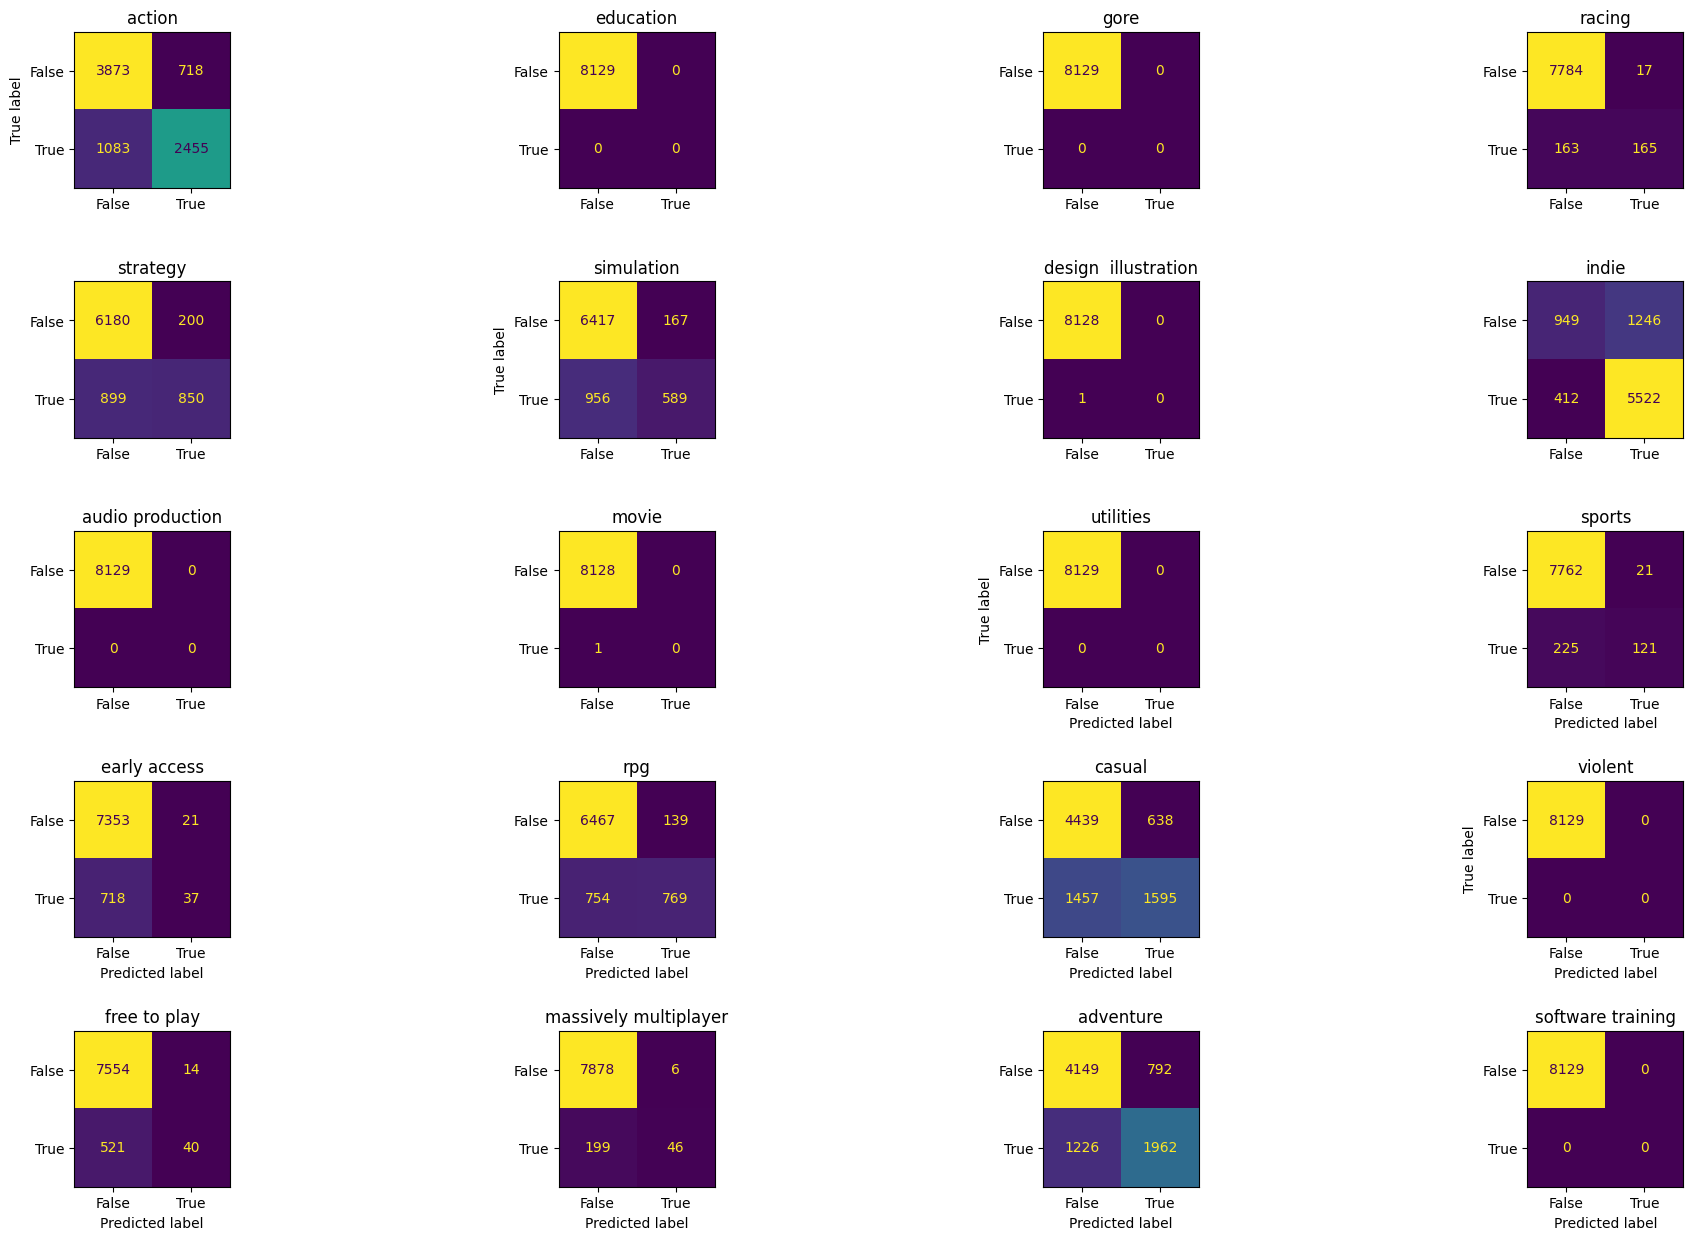

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

f, axes = plt.subplots(5, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(len(conf)):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf[i], display_labels=("False", "True"))
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(y_labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0, hspace=0.6)
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues)
plt.show()

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(200)
# pca.fit(X)
# sparse_X = pca.components_

# accuracy = cross_val_score(classifier, sparse_X, y, cv=2, scoring='accuracy')
# print(np.mean(accuracy))

The below cell takes almost 15 minutes to run and produces 0.16 accuracy

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# classifier = RandomForestClassifier(n_estimators=100)
# accuracy = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')
# print(np.mean(accuracy))

0.16719631669356366


# Sample Testing

In [76]:
sample_testing_results = []

In the cell below, enter the title and description of any game in the steam library that was published after 2020. Compare the listed genres in the store page to those output here.

In [ ]:
title = "Hades II"
description = ["Battle beyond the Underworld using dark sorcery to take on the Titan of Time in this bewitching sequel to the award-winning rogue-like dungeon crawler."]
actual = ["action", "indie", "rpg", "early access"]

In [ ]:
classifier = OneVsRestClassifier(LinearSVC(C=0.9, loss='hinge', max_iter=50000))
classifier.fit(X, y)
print("Classifier Trained")

Classifier Trained


In [ ]:
sample = TfidfVectorizer(vocabulary=tv.vocabulary_, smooth_idf=True, sublinear_tf=True, max_df=0.5, min_df=5, lowercase=True, stop_words='english')
sample_result = sample.fit_transform(description)
y_pred = classifier.predict(sample_result)

result = []
for label in range(len(y_labels)):
    if y_pred[0][label] != 0:
        result.append(y_labels[label])

trained = np.isin(title, data[:, 2])
correct = 0
incorrect = 0
for genre in result:
    if genre in actual:
        correct += 1
    else:
        incorrect += 1
correct_ratio = "" + str(correct) + "/" + str(len(actual))
test_output = [trained, title, description[0], actual, result, correct_ratio, incorrect]


sample_testing_results.append(test_output)

columns = ['Already in training set', 'Title', 'Description', 'Actual genres', 'Predicted Genres', 'Correct Genres', 'Incorrect Genres']
pd.DataFrame(sample_testing_results, columns=columns)

,Already in training set,Title,Description,Actual genres,Predicted Genres,Correct Genres,Incorrect Genres
0,False,Hades II,Battle beyond the Underworld using dark sorcer...,"[action, indie, rpg, early access]",[indie],1/4,0
